### Train a VLM in Google Colab!

### Clone the repository if you don't have it already

In [ ]:
import os

if not os.path.isdir('nanoVLM'):
    !git clone https://github.com/huggingface/nanoVLM.git
%cd nanoVLM/
!ls

### Imports and Setup

In [ ]:
# If you get an "Error" from pip's dependency resolver but the cell complets fine, this is not an issue, you can continue :)
!pip -q install torch
!pip -q install gcsfs
!pip -q install datasets==3.5.0
!pip -q install tqdm
!pip -q install huggingface_hub

In [ ]:
# Let's authentificate with the Hugging Face Hub so you can push your model
from huggingface_hub import notebook_login
notebook_login()

In [1]:
# Decide on the name of your model here!
# You will need your HF user name and the name you want to give to it
# For me, this would be "lusxvr/nanoVLM"
hf_model_name = "hosseinj/nanoVLM"

In [2]:
# nanoVLM Imports (please check out the implementations in detail, that's where all the interessting stuff is!)
from data.collators import VQACollator, MMStarCollator
from data.datasets import MMStarDataset, VQADataset
from data.processors import get_image_processor, get_tokenizer
from models.vision_language_model import VisionLanguageModel
import models.utils as utils

# Libraries
import math
import time
import torch
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets

#Otherwise, the tokenizer will through a warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# To reload the modules if you change something in the code
%reload_ext autoreload
%autoreload 2

Using device: cuda


### Get the dataloaders

In [6]:
def get_dataloaders(train_cfg, vlm_cfg):
    # Create datasets
    image_processor = get_image_processor(vlm_cfg.vit_img_size)
    tokenizer = get_tokenizer(vlm_cfg.lm_tokenizer, vlm_cfg.vlm_extra_tokens, vlm_cfg.lm_chat_template)

    # Load and combine all training datasets
    combined_train_data = []
    for dataset_name in train_cfg.train_dataset_name:
        train_ds = load_dataset(train_cfg.train_dataset_path, dataset_name)
        combined_train_data.append(train_ds['train'])
    train_ds = concatenate_datasets(combined_train_data)
    
    test_ds = load_dataset(train_cfg.test_dataset_path)
    train_ds = train_ds.shuffle(seed=0) # Shuffle the training dataset, so train and val get equal contributions from all concatinated datasets

    # Apply cutoff if specified
    if train_cfg.data_cutoff_idx is None:
        total_samples = len(train_ds)  # Use the entire dataset
    else:
        total_samples = min(len(train_ds), train_cfg.data_cutoff_idx)

    val_size = int(total_samples * train_cfg.val_ratio)
    train_size = total_samples - val_size

    train_dataset = VQADataset(train_ds.select(range(train_size)), tokenizer, image_processor, vlm_cfg.mp_image_token_length)
    val_dataset = VQADataset(train_ds.select(range(train_size, total_samples)), tokenizer, image_processor, vlm_cfg.mp_image_token_length)
    test_dataset = MMStarDataset(test_ds['val'], tokenizer, image_processor, vlm_cfg.mp_image_token_length)

    # Create collators
    vqa_collator = VQACollator(tokenizer, vlm_cfg.lm_max_length)
    mmstar_collator = MMStarCollator(tokenizer)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=True,
        collate_fn=vqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=False,
        collate_fn=vqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        test_dataset, 
        batch_size=train_cfg.mmstar_batch_size, 
        shuffle=False, 
        collate_fn=mmstar_collator,
        pin_memory=True,
        )

    return train_loader, val_loader, test_loader

### Prepare the testing function

In [7]:
def test_mmstar(model, tokenizer, test_loader, device):
    # Go through MMStar and count how many answers we get right
    model.eval()
    total_examples = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in test_loader:
            image = batch['images'].to(device)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            correct_answer = tokenizer.batch_decode(labels, skip_special_tokens=True)

            gen = model.generate(input_ids, image, attention_mask, greedy=True)
            model_output = tokenizer.batch_decode(gen, skip_special_tokens=True)

            is_correct = utils.check_multiple_choice_with_regex(model_output, correct_answer)

            total_examples += len(is_correct)
            if is_correct:
                correct_predictions += sum(is_correct)

    accuracy = correct_predictions / total_examples if total_examples > 0 else 0
    model.train()
    return accuracy

### Prepare the training loop

In [8]:
def get_lr(it, max_lr, max_steps):
    min_lr = max_lr * 0.1
    warmup_steps = max_steps * 0.03
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

def train(train_cfg, vlm_cfg):
    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, vlm_cfg)
    tokenizer = get_tokenizer(vlm_cfg.lm_tokenizer, vlm_cfg.vlm_extra_tokens, vlm_cfg.lm_chat_template)

    # Initialize model
    if train_cfg.resume_from_vlm_checkpoint:
        model = VisionLanguageModel.from_pretrained(vlm_cfg.vlm_checkpoint_path)
    else:
        model = VisionLanguageModel(vlm_cfg)

    print(f"nanoVLM initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
    print(f"Training summary: {len(train_loader.dataset)} samples, {len(train_loader)} batches/epoch, batch size {train_cfg.batch_size}")

    # Define optimizer groups
    param_groups = [{'params': model.MP.parameters(), 'lr': train_cfg.lr_mp},
                    {'params': list(model.decoder.parameters()) + list(model.vision_encoder.parameters()), 'lr': train_cfg.lr_backbones}]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    epoch_times = []
    batch_losses = []
    val_losses = []
    val_plot_steps = []
    best_accuracy = 0
    global_step = 0
    for epoch in range(train_cfg.epochs):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        total_tokens_processed = 0

        for batch in tqdm(train_loader):
            batch_start_time = time.time()
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16): # Mixed precision training
                _, loss = model(input_ids, images, attention_mask=attention_mask, targets=labels)

            loss.backward()

            adj_lr_mp = get_lr(global_step, train_cfg.lr_mp, len(train_loader) * train_cfg.epochs)
            adj_lr_backbones = get_lr(global_step, train_cfg.lr_backbones, len(train_loader) * train_cfg.epochs)
            optimizer.param_groups[0]['lr'] = adj_lr_mp
            optimizer.param_groups[1]['lr'] = adj_lr_backbones

            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            num_tokens = torch.sum(attention_mask).item() # Sum of attention mask gives number of tokens
            num_tokens += images.shape[0] * ((images.shape[2] / vlm_cfg.vit_patch_size) ** 2) / (vlm_cfg.mp_pixel_shuffle_factor ** 2) # Add image tokens = batch_size * (((img_size / patch_size) ** 2) / (pixel_shuffle_factor ** 2))
            total_tokens_processed += num_tokens

            batch_end_time = time.time()
            batch_duration = batch_end_time - batch_start_time
            tokens_per_second = num_tokens / batch_duration

            if global_step % 5 == 0:
                model.eval()
                torch.cuda.empty_cache()  # Clear GPU memory
                with torch.no_grad():
                    total_val_loss = 0
                    for batch in val_loader:
                        images = batch["image"].to(device)
                        input_ids = batch["input_ids"].to(device)
                        labels = batch["labels"].to(device)
                        attention_mask = batch["attention_mask"].to(device)

                        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                            _, loss = model(input_ids, images, attention_mask=attention_mask, targets=labels)

                        total_val_loss += loss.item()
                    avg_val_loss = total_val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)
                    val_plot_steps.append(global_step)
                epoch_accuracy = 0
                if train_cfg.eval_in_epochs:
                    epoch_accuracy = test_mmstar(model, tokenizer, test_loader, device)
                    if epoch_accuracy > best_accuracy:
                      best_accuracy = epoch_accuracy
                      model.save_pretrained(save_directory=vlm_cfg.vlm_checkpoint_path)
                    print(f"\nStep: {global_step}, Loss: {batch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Tokens/s: {tokens_per_second:.2f}, Accuracy: {epoch_accuracy:.4f}")
                model.train()

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        epoch_tokens_per_second = total_tokens_processed / epoch_duration

        print(f"Epoch {epoch+1}/{train_cfg.epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {epoch_duration:.2f}s | T/s: {epoch_tokens_per_second:.2f}")

    # Summary Statistics
    if not train_cfg.eval_in_epochs:
      model.save_pretrained(save_directory=vlm_cfg.vlm_checkpoint_path)
    #   model.push_to_hub(hf_model_name)


    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    total_training_time = sum(epoch_times)
    total_samples_processed = len(train_loader.dataset) * train_cfg.epochs
    avg_time_per_sample = total_training_time / total_samples_processed
    print(f"Average time per epoch: {avg_epoch_time:.2f}s")
    print(f"Average time per sample: {avg_time_per_sample:.4f}s")

    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # With this code you can test the accuracy of the model on the MMStar dataset
    # But if you only train with few samples, the accuracy will be very low
    # print("Testing MMStar Accuracy:")
    # accuracy = test_mmstar(model, tokenizer, test_loader, device)
    # print(f"MMStar Accuracy: {accuracy:.4f}")

### Prepare the Configs
Instead of using the config.py file in the repo (which was created to run on one H100), we will create our config here to play around with the parameters easier and adapt them to colabs capabilities

In [9]:
@dataclass
class VLMConfig:
    vit_hidden_dim: int = 768
    vit_inter_dim: int = 4 * vit_hidden_dim
    vit_patch_size: int = 16
    vit_img_size: int = 224
    vit_n_heads: int = 12
    vit_dropout: float = 0.0
    vit_n_blocks: int = 12
    vit_ln_eps: float = 1e-6
    vit_cls_flag: bool = False
    vit_model_type: str = 'google/siglip-base-patch16-224'

    lm_hidden_dim: int = 576
    lm_inter_dim: int = 1536
    lm_rms_eps: float = 1e-5
    lm_re_base: int = 100000
    lm_max_position_embeddings: int = 8192
    lm_base_vocab_size: int = 49152
    extra_token_amount: int = 1  # Number of extra tokens for the VLM (image start, image end, image token)
    lm_vocab_size: int = lm_base_vocab_size + extra_token_amount # Not a great way to do this, but it works for now (vlm_extra_tokens cannot be a dict, since this is mutable, and a Field has no len() function)
    lm_n_heads: int = 9
    lm_n_kv_heads: int = 3
    lm_dropout: float = 0.0
    lm_n_blocks: int = 30
    lm_attn_scaling: float = 1.0
    lm_eos_token_id: int = 0
    lm_max_length: int = 128
    lm_use_tokens: bool = False # Decide if the LM expects tokens or embeddings as input (if using as a backbone for the VLM, set to False)
    lm_tie_weights: bool = True # Decide if you want to tie the LM Head weight to the token embedding weights
    lm_model_type: str = 'HuggingFaceTB/SmolLM2-135M'
    lm_tokenizer: str = 'HuggingFaceTB/cosmo2-tokenizer'
    lm_chat_template: str = "You are a helpful assistant. Answer the question based on the provided image and context. If the question is not answerable, respond with 'I don't know'.\n\nImage: {image}\nContext: {context}\nQuestion: {question}\nAnswer:"
    mp_pixel_shuffle_factor: int = 2
    mp_image_token_length: int = 49

    vlm_extra_tokens: dict[str, str] = field(default_factory=lambda: {"image_token": "<|image|>"})#, "boi_token": "<|image_start|>", "eoi_token": "<|image_end|>"})
    vlm_load_backbone_weights: bool = True
    vlm_checkpoint_path: str = 'checkpoints'
    hf_repo_name: str = 'nanoVLM'


@dataclass
class TrainConfig:
    lr_mp: float = 1e-3
    lr_backbones: float = 5e-5
    val_ratio: float = 0.2
    compile: bool = False
    data_cutoff_idx: int = 16 # Let's only use a small subset of the data at first, otherwise it takes very long to see anything :D
    batch_size: int = 1
    mmstar_batch_size: int = 1
    epochs: int = 1
    eval_in_epochs: bool = False # Deactivating this in colab, because it would evaluate 1500 samples of MMStar every time otherwise
    resume_from_vlm_checkpoint: bool = False # Indicate if the training should be resumed from a checkpoint of the whole VLM or you want to start from scratch
    train_dataset_path: str = 'HuggingFaceM4/the_cauldron'
    train_dataset_name: tuple[str, ...] = ("tqa", "vsr") #All options; ("ai2d", "aokvqa", "chart2text", "chartqa", "clevr", "cocoqa", "datikz", "diagram_image_to_text", "docvqa", "dvqa", "figureqa", "finqa", "geomverse", "hateful_memes", "hitab", "iam", "iconqa", "infographic_vqa", "intergps", "localized_narratives", "mapqa", "multihiertt", "ocrvqa", "plotqa", "raven", "rendered_text", "robut_sqa", "robut_wikisql", "robut_wtq", "scienceqa", "screen2words", "st_vqa", "tabmwp", "tallyqa", "tat_qa", "textcaps", "textvqa", "tqa", "vistext", "visual7w", "visualmrc", "vqarad", "vqav2", "vsr", "websight") # "clevr_math", "okvqa", "spot_the_diff", "nlvr2", "mimic_cgd",
    test_dataset_path: str = "Lin-Chen/MMStar"

### Lets run the training!

Loading from backbone weights
Successfully loaded google/siglip-base-patch16-224 weights from safetensors. Model has 85,797,120 parameters.
Extending token embeddings from torch.Size([49152, 576]) to torch.Size([49153, 576])
Initialized 1 new token embeddings
Successfully loaded HuggingFaceTB/SmolLM2-135M weights from safetensors. Model has 134,515,584 parameters.
nanoVLM initialized with 222,082,176 parameters
Training summary: 13 samples, 13 batches/epoch, batch size 1


  0%|          | 0/13 [00:00<?, ?it/s]

Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])
Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])
Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])


  8%|▊         | 1/13 [00:01<00:20,  1.74s/it]

Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])
Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])


 15%|█▌        | 2/13 [00:02<00:10,  1.07it/s]

Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])


 23%|██▎       | 3/13 [00:02<00:06,  1.46it/s]

Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])


 31%|███       | 4/13 [00:02<00:05,  1.78it/s]

Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])


 38%|███▊      | 5/13 [00:03<00:03,  2.03it/s]

Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])
Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])
Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])


 46%|████▌     | 6/13 [00:04<00:04,  1.51it/s]

Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])
Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])


 54%|█████▍    | 7/13 [00:04<00:03,  1.76it/s]

Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])


 62%|██████▏   | 8/13 [00:04<00:02,  1.98it/s]

Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])


 69%|██████▉   | 9/13 [00:05<00:01,  2.16it/s]

Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])


 77%|███████▋  | 10/13 [00:05<00:01,  2.31it/s]

Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])
Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])
Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])


 85%|████████▍ | 11/13 [00:06<00:01,  1.65it/s]

Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])
Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])


 92%|█████████▏| 12/13 [00:07<00:00,  1.87it/s]

Found 0 image tokens
Image embeddings shape: torch.Size([1, 49, 576])


100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Epoch 1/1 | Train Loss: 0.0465 | Val Loss: 0.0003 | Time: 7.49s | T/s: 180.44
Average time per epoch: 7.49s
Average time per sample: 0.5764s


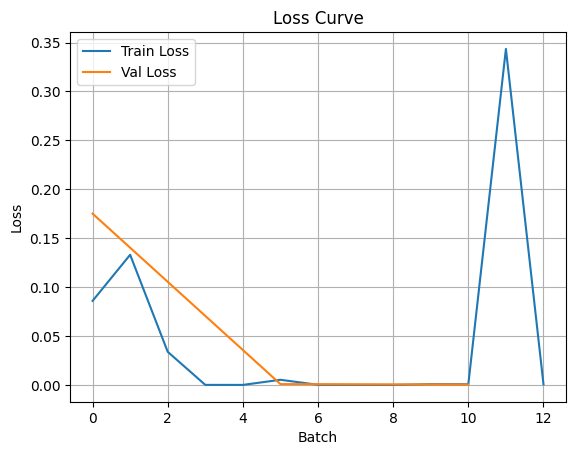

In [10]:
vlm_cfg = VLMConfig()
train_cfg = TrainConfig()
train(train_cfg, vlm_cfg)

As you can see the model trains, so feel free to play around with the architecture or data! Let us know what you build with it!

PS: If you want to test the model, check out generate.py to see how to do inference with it